# Back Forward Filtering Guiding


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update("jax_enable_x64", True)
from jax import numpy as jnp
from jax.random import PRNGKey, split

from hyperiax.execution import OrderedExecutor
from hyperiax.models import UpLambdaReducer, DownLambda, UpLambda

from hyperiax.tree.topology import read_topology, TopologyNode
from hyperiax.tree import HypTree

from hyperiax.plotting import plot_tree, plot_tree_text, plot_shape_2d, plot_tree_2d_scatter, plot_tree_2d_shape

from hyperiax.mcmc import ParameterStore, VarianceParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.statistics import gelman_rubin
from hyperiax.mcmc.plotting import trace_plots

# Custom Python Modules
from SDE import dts, dot, solve, forward
from ABFFG import *

import matplotlib.pyplot as plt
from tqdm import tqdm

import pandas as pd

In [3]:
# Seed
seed = 42
key = PRNGKey(seed)

## SDE setup

In [4]:
n_steps = 20 # Steps in the discretization

# Drift
def b(t,x,params): return jnp.zeros(n*d)

# Normalized kernel for diffusion field
kQ12 = lambda x,params: (1/n)*k_K2(x,params)

# Evaluate kernel between all pairs of landmarks from two shapes
kQ12_q = lambda q1,q2,params: kQ12(q1.reshape((-1,d))[:,jnp.newaxis,:]-q2.reshape((-1,d))[jnp.newaxis,:,:],params)

"""Diffusion field for SDE at configuration q.
    
    Args:
        q: Current landmark positions, shape (n * d,) or (n, d).
        params: Kernel parameters.
    Returns:
        Diffusion matrix, shape (n, n).
    """
sigma = lambda q,theta: kQ12_q(q,q,theta)

"""Covariance matrix of the increments at q.
    
    Args:
        q: Landmark positions.
        params: Kernel parameters.
    Returns:
        Covariance matrix, shape (n, n).
    """
def a(q,theta): sigmaq = sigma(q,theta); return jnp.einsum('ij,kj->ik',sigmaq,sigmaq) # covariance

## Load data

In [5]:
# Dimension
d = 2

tree_path = "./tree/"
data_path = "./data/"

filename = tree_path + "malesub1.txt"
filename_csv  = data_path + "male.csv"

## Create tree

HypTree(size=22, levels=8, leaves=11, inner nodes=10)
                                                                                                               prior
                                                                                                                 │
                                                                                                                root
                                                                      ┌──────────────────────────────────────────┴──────────────────────────────────────────┐
                                                                    xx_191                                                                                xx_192                     
                                                 ┌────────────────────┴────────────────────┐                                                 ┌──────────────┴───────────────┐        
                                               xx_224                      

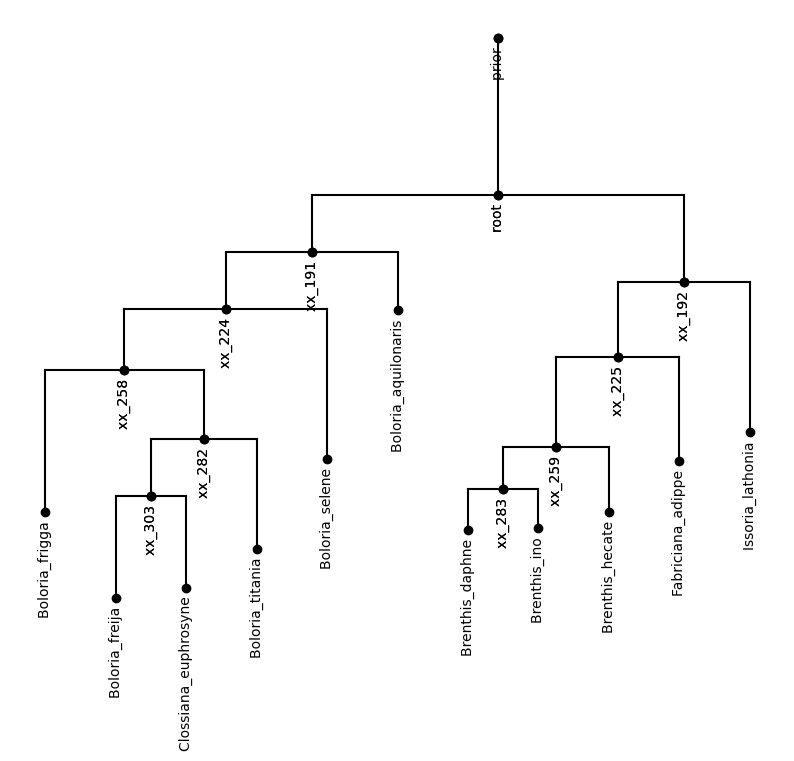

In [6]:
# Read the tree file
with open(filename, "r") as file:
    string_tree = file.read()

# Tree structure
data_tree = read_topology(string_tree)
topology = data_tree.topology_root

# Add an artificial 'prior' root node to standardize the tree structure
root = TopologyNode(parent=None,children=[topology])
topology.parent = root
root.name = "prior"; topology.name = "root"

# Build the tree object
tree = HypTree(root)

# Copy edge lengths from the data and set root edge length as mean of doubled edges
tree.add_property('edge_length', shape=())
tree.data['edge_length'] = tree.data['edge_length'].at[1:].set(data_tree.data['edge_length'][:,0])
tree.data['edge_length'] = tree.data['edge_length'].at[1].set(jnp.mean(2*data_tree.data['edge_length']))

print(tree)
plot_tree_text(tree)
plot_tree(tree,inc_names=True)

## Handle landmark data

In [7]:
# Load shape data

landmarks = pd.read_csv(filename_csv, sep=",", header = 0)

node_names= [ node.name for node in list(tree.iter_topology_bfs())]
node_names[1] = "xx_0" # Because root was renamed

# Reindex the landmarks DataFrame to match BFS node order, skipping 'prior'
landmarks = landmarks.set_index('node_names')
landmarks = landmarks.reindex(node_names[1:]) # [1:] skips the artificial prior

# Remove any non-coordinate columns (like "edges")
landmarks = landmarks.drop(columns="edges")
    
# Convert to numpy array for computation
landmarks = landmarks.to_numpy()
# Check for NaN values in landmarks array
nan_rows = jnp.where(jnp.isnan(landmarks).any(axis=1))[0]
if len(nan_rows) > 0:
    print("Warning: NaN values found in landmarks array at row(s):", nan_rows)

# Number of landmarks per configuration
n = landmarks.shape[1]//d
print("n landmarks: ",n)


n landmarks:  118


In [8]:
landmarks = landmarks.reshape((-1,n,d))
landmarks = jnp.delete(landmarks,66,axis=1) # Drop row with coinciding landmarks
landmarks = landmarks.reshape((landmarks.shape[0],-1))
n = landmarks.shape[1]//d
print("n landmarks after removing coinciding landmarks: ",landmarks.shape)


n landmarks after removing coinciding landmarks:  (21, 234)


In [9]:
# (OPTIONAL) Subsample
# landmarks = landmarks.reshape((-1, n, d))
# landmarks = landmarks[:, ::4, :].reshape((landmarks.shape[0], -1))
# n = landmarks.shape[1] // d
# print("n landmarks after subsampling: ", n)

In [10]:
# Scale landmarks
n_shapes = landmarks.shape[0]
landmarks = 1e-3*landmarks.reshape((n_shapes,-1,d))[:,::1].reshape((n_shapes,-1))


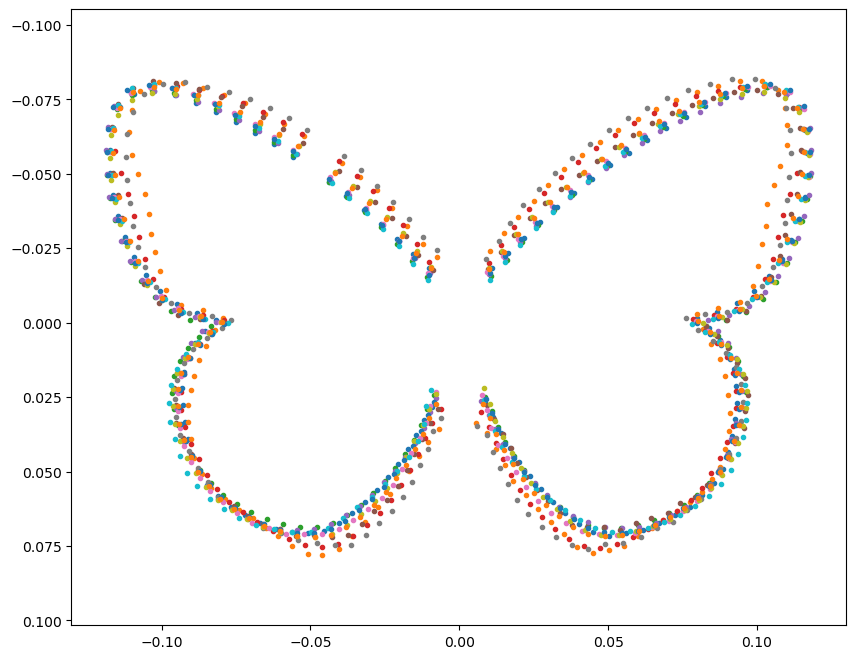

In [11]:
# Assign landmarks as a property to each node (except 'prior')
tree.add_property('value', shape=(n_steps+1, n*d))
tree.data['value'] = tree.data['value'].at[1:].set(landmarks[:, None, :])  # add landmarks for leaves

# Gather leaf node values (for prior mean)
leaf_values = tree.data['value'][tree.is_leaf][:, -1]

# Add a property for simulation noise (to be used later)
tree.add_property('noise', shape=(n_steps, n*d))

# Set the prior value at the root (mean of leaf values)
tree.data['value'] = tree.data['value'].at[0].set(jnp.mean(leaf_values, 0))

# Plot shapes: leaves and root prior
fig, ax = plt.subplots(figsize=(10, 8))
for leaf in tree.iter_topology_leaves_bfs():
    plot_shape_2d(tree.data['value'][leaf.id][-1], ax=ax)
plot_shape_2d(tree.data['value'][0][0], ax=ax)
ax.invert_yaxis()
plt.show()

## Gaussian Kernel

In [12]:
k_Gaussian = lambda x,params: params['k_alpha']/2*jnp.exp(-.5*jnp.sum(jnp.square(x)/params['k_sigma'],2))
r = lambda x,params: jnp.sqrt(1e-7+jnp.sum(jnp.square(x/params['k_sigma']),2))

# Define kernel
def k_K2(x,params): 
    """ Laplace K2 kernel"""
    r_ = r(x,params)
    return params['k_alpha']/2*4*(3+3*r_+r_**2)*jnp.exp(-r_)

In [13]:
# Parameters, variance and observation noise
params = ParameterStore({
    'k_alpha': VarianceParameter(.1), # Kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.2), # Kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(.005) # Observation noise variance
    })

Now follows the down transitions using the SDE functions above. The step covariance is square of the pairwise kernel evaluations in `sigma(params)` times the variance parameter times edge lengths.

In [14]:
# vmapped version of down_unconditional. In this version, the function takes a single node, not a batch (contrast to the batched version in mcmc_Gaussian_BFFG.ipynb)
@jax.jit
def down_unconditional(noise,edge_length,parent_value,params,**args):
    def f(noise,edge_length,parent_value):
        var = edge_length # variance is edge length
        _dts = dts(T=var,n_steps=n_steps); _dWs = jnp.sqrt(_dts)[:,None]*noise
        Xs = forward(parent_value.reshape((-1,n*d))[-1],_dts,_dWs,b,sigma,params)
        return {'value': Xs}

    return jax.vmap(f)(noise,edge_length,parent_value)
downmodel_unconditional = DownLambda(down_fn=down_unconditional)
down_unconditional = OrderedExecutor(downmodel_unconditional)

We can now draw noise and perform a downwards pass. This gives values at all nodes of the tree. Note that observation noise is not added to the leaves yet.

In [15]:
# sample new noise
def update_noise(tree,key): 
    tree.data['noise'] = jax.random.normal(key, shape=tree.data['noise'].shape)

subkey, key = split(key)
update_noise(tree,subkey)
down_unconditional.down(tree,params.values())

In [16]:
## add noise to leaf nodes (only for testing)
key, subkey = split(key)
trajectories = tree.data['value'][tree.is_leaf]
trajectories = trajectories.at[:,-1].add(jnp.sqrt(params['obs_var'].value)*jax.random.normal(subkey,trajectories[:,-1].shape))
leaf_values = trajectories[:,-1]
tree.data['value'] = tree.data['value'].at[tree.is_leaf].set(trajectories)

Plot a generated tree.

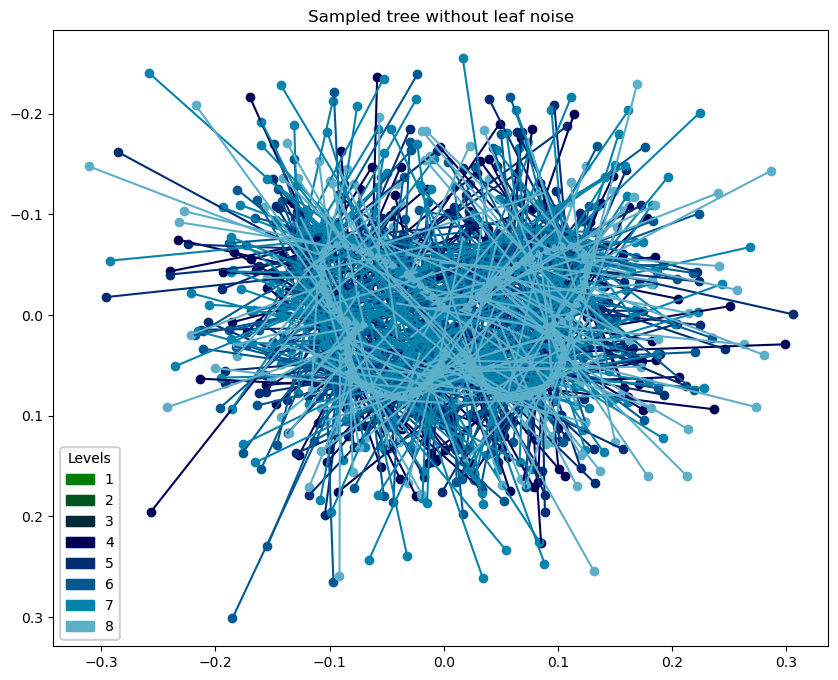

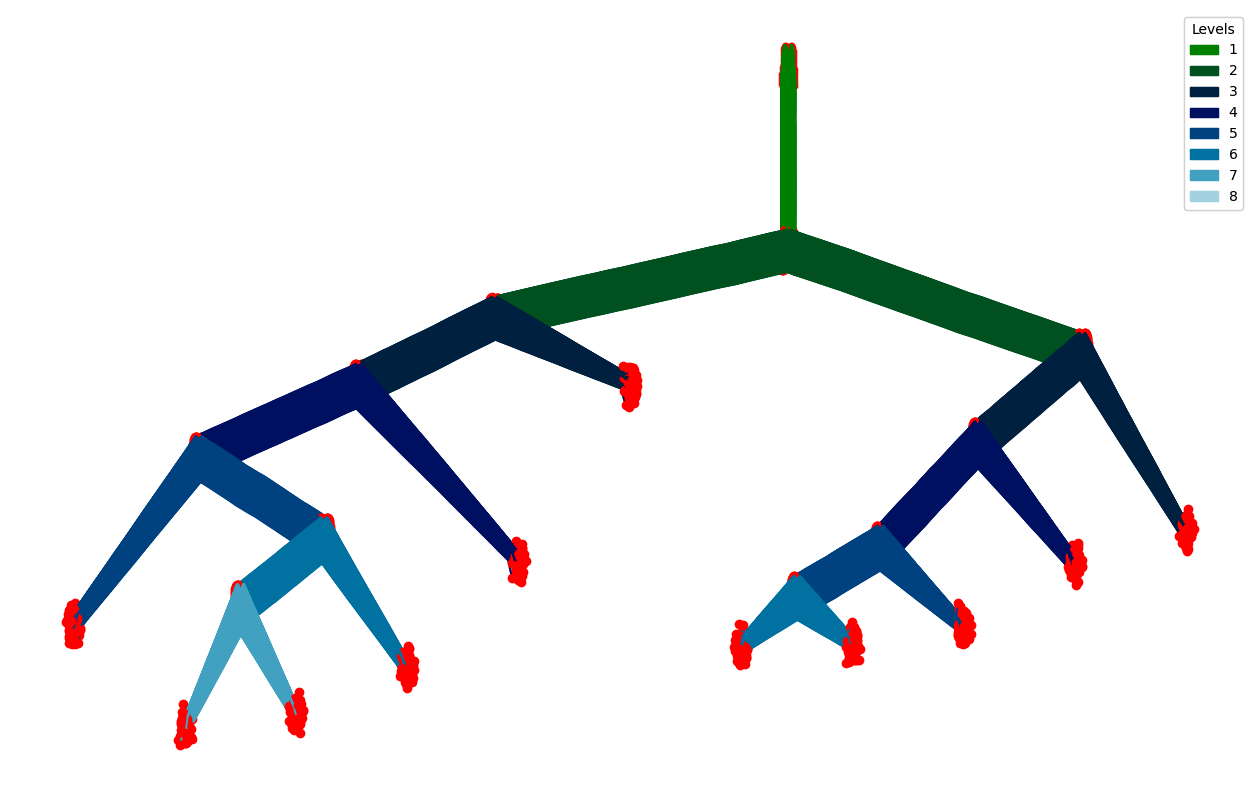

In [17]:
if tree.depth < 10:
    fig,ax = plt.subplots(figsize=(10,8))
    plot_tree_2d_scatter(tree,'value',selector=lambda z: z.reshape((-1,n,d)),ax=ax)
    plt.gca().set_title('Sampled tree without leaf noise')
    ax.invert_yaxis()
    ax.grid(False)
    plot_tree_2d_shape(tree,'value')

## Definition of the Backwards Filter

In [ ]:
# Backwards Filter
@jax.jit
def up(noise,edge_length,F_T,H_T,tildea,params,**args):
    def f(edge_length,F_T,H_T,tildea):
        var = edge_length # variance is edge length
        T = var # running time of Brownian motion

        _ts = jnp.cumsum(jnp.concatenate((jnp.array([0.]), dts(T=T,n_steps=n_steps))))[:-1]
        Phi_inv = lambda t:  jnp.eye(n)+H_T@tildea*(T-t)
        H_0 = solve(Phi_inv(0),H_T).reshape(H_T.shape)
        F_0 = solve(Phi_inv(0),F_T).reshape(F_T.shape)
        v_T = solve(H_T,F_T)
        
        c_0 = jax.vmap(lambda v_T: logphi_H(jnp.zeros(n),v_T,H_0),1)(v_T.reshape((n,d)))
        return {'c_0': c_0, 'F_0': F_0, 'H_0': H_0}
    return jax.vmap(f)(edge_length,F_T,H_T,tildea)
def transform(child_c_0,child_F_0,child_H_0,params,**args):
    F_T = child_F_0
    H_T = child_H_0
    c_T = child_c_0
    v_T = jax.vmap(lambda H,F: solve(H,F))(H_T,F_T)
    tildea = jax.vmap(lambda v: a(v,params))(v_T)
    return {'c_T': c_T, 'F_T': F_T, 'H_T': H_T, 'tildea': tildea}
upmodel = UpLambdaReducer(up, transform,
                   reductions={
                       'c_0': 'sum',
                       'F_0': 'sum',
                       'H_0': 'sum',
                    }
        )
up = OrderedExecutor(upmodel)

## Initialize tree for upwards pass

In [ ]:
# Initialize tree for up
tree.add_property('c_0', shape=(d,)); tree.add_property('F_0', shape=(n*d,)); tree.add_property('H_0', shape=(n,n)); tree.add_property('c_T', shape=(d,)); tree.add_property('F_T', shape=(n*d,)); tree.add_property('H_T', shape=(n,n)); tree.add_property('logpsi'); tree.add_property('tildea', shape=(n,n))
def init_up(leaf_values,params):
    tree.data['value'] = tree.data['value'].at[tree.is_leaf].set(tree.data['value'][tree.is_leaf].at[:,-1].set(leaf_values))
    tree.data['H_T'] = tree.data['H_T'].at[tree.is_leaf].set((jnp.eye(n)/params['obs_var'].value)[None,:,:])
    tree.data['F_T'] = tree.data['F_T'].at[tree.is_leaf].set(jax.vmap(lambda H,v: dot(H,v))(tree.data['H_T'][tree.is_leaf],leaf_values))
    Sigma = params['obs_var'].value*jnp.eye(n)
    tree.data['c_T'] = tree.data['c_T'].at[tree.is_leaf].set(jax.vmap(lambda v: jax.vmap(lambda v: logphi(jnp.zeros(n),v,Sigma),1)(v.reshape((n,d))))(leaf_values))
    tree.data['tildea'] = tree.data['tildea'].at[tree.is_leaf].set(jax.vmap(lambda v: a(v,params.values()))(leaf_values))


## Define the Forward Guiding (conditional downwards pass)

In [20]:
@jax.jit
def down_conditional(noise,edge_length,F_T,H_T,tildea,parent_value,params,**args):
    def f(noise,edge_length,F_T,H_T,tildea,parent_value):
        var = edge_length # variance is edge length
        _dts = dts(T=var,n_steps=n_steps)
        _dWs = jnp.sqrt(_dts)[:,None]*noise
        Xs,logpsi = forward_guided(parent_value.reshape((-1,n*d))[-1],H_T,F_T,tildea,_dts,_dWs,b,sigma,params)
        return {'value': Xs, 'logpsi': logpsi}

    return jax.vmap(f)(noise,edge_length,F_T,H_T,tildea,parent_value)
downmodel_conditional = DownLambda(down_fn=down_conditional)
down_conditional = OrderedExecutor(downmodel_conditional)

## Timing Backwards Filter and Forward Guiding

In [ ]:
# Backwards Filter and Forward Guiding
init_up(leaf_values,params)
up.up(tree,params.values())
down_conditional.down(tree,params.values())

# Time
subkey, key = split(key)
update_noise(tree,subkey)
down_unconditional.down(tree,params.values())
%time down_unconditional.down(tree,params.values()); jax.block_until_ready(tree.data['value'])
%time down_conditional.down(tree,params.values()); jax.block_until_ready(tree.data['value'])
%time up.up(tree,params.values()); jax.block_until_ready(tree.data['H_0'])
None

CPU times: user 10.3 s, sys: 393 ms, total: 10.7 s
Wall time: 1.37 s
CPU times: user 11.8 s, sys: 551 ms, total: 12.4 s
Wall time: 1.6 s
CPU times: user 1.14 s, sys: 24.5 ms, total: 1.16 s
Wall time: 151 ms


## MCMC run with likelihood ratios from Gaussian approximation

In [ ]:
# Inference for Gaussian model, likelihood from forward guiding

# Crank-Nicolson update with possibly node-dependent lambd
lambd = .9
update_CN = lambda noise,key: noise*lambd+jnp.sqrt((1-lambd**2))*jax.random.normal(key,noise.shape)

# Log likelihood of the tree under the Gaussian approximation with correction factors
def log_likelihood(data,state):
    """Log likelihood of the tree."""
    params,noise = state
    
    # Backwards filtering with current parameters
    init_up(data,params); up.up(tree,params.values())
    
    # Forwards guiding with current noise
    tree.data['noise'] = noise; down_conditional.down(tree,params.values())
    v,c,F,H = tree.data['value'][tree.is_root][:,0],tree.data['c_T'][tree.is_root],tree.data['F_T'][tree.is_root],tree.data['H_T'][tree.is_root]
    v = jnp.squeeze(v); c = jnp.squeeze(c); F = jnp.squeeze(F); H = jnp.squeeze(H)
    tree_log_likelihood = c.sum()+F@v-.5*v.T@dot(H,v)
    tree_logpsi = jnp.mean(tree.data['logpsi'][1:])
    residuals = tree.data['value'][tree.is_leaf][:,-1]-data
    leaves_log_likelihood = jnp.mean(jax.scipy.stats.norm.logpdf(residuals,0,jnp.sqrt(params['obs_var'].value)))
    return tree_log_likelihood+tree_logpsi+leaves_log_likelihood

def log_posterior(data,state):
    """Log posterior given the state and data."""
    parameters,_ = state
    log_prior = parameters.log_prior()
    log_like = log_likelihood(data,state)
    return log_prior + log_like

def proposal(data, state, key):
    subkeys = jax.random.split(key,2)
    parameters,noise = state

    # Update parameters
    new_parameters = parameters.propose(subkeys[0])
    
    # Update noise
    new_noise = update_CN(noise,subkeys[1])

    return new_parameters,new_noise

# Tree values and parameters
init_params = ParameterStore({
    'k_alpha': VarianceParameter(0.25,alpha=2,beta=.2), # Kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.25,alpha=2,beta=.15,max=1.), # Kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(0.001,alpha=2,beta=.01) # Observation noise variance
    })
print("Initial parameters: ",init_params.values())

# Initial state with inital set parameters
init_state = (init_params,jnp.zeros_like(tree.data['noise']))



Initial parameters:  {'k_alpha': 0.25, 'k_sigma': 0.25, 'obs_var': 0.001}


In [ ]:
# Run Metropolis-Hastings
n_chains = 4
from dask.distributed import Client, LocalCluster
n_workers = min(n_chains,8)

# Try to connect to existing cluster, create new one if none exists
try:
    client = Client("tcp://localhost:8787",timeout=5)
except OSError:
    cluster = LocalCluster(n_workers=n_workers)
    client = Client(cluster)

# Parallel chains
subkey, key = split(key)
subkeys = jax.random.split(key, n_chains)  # One key per chain

import warnings
import copy
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning, message=".*Sending large graph.*")
    futures = []
    for i in range(n_chains):  # 4 chains
        key, subkey = split(subkeys[i])
        chain_init_state = (init_params.propose(key),init_state[1])
        future = client.submit(metropolis_hastings, log_posterior, proposal, leaf_values,
                             chain_init_state, 200, burn_in=20, rng_key=subkey,
                             savef=lambda state: state[0])
        futures.append(future)

results = client.gather(futures)
log_likelihoods = [r[0] for r in results]  # Extract log likelihoods from each chain
samples = [r[1] for r in results]  # Extract samples from each chain

# Log likelihoods for each chain
plt.figure(figsize=(10,6))
for k in range(n_chains):
    plt.plot(log_likelihoods[k], label=f'Chain {k+1}')
plt.xlabel("Iterations")
plt.ylabel("Log Likelihood")
plt.title('Log likelihood per chain')
plt.legend()
plt.show()

# Trace plots for each chain
for k in range(n_chains):
    print(f"\nChain {k+1}:")
    trace_plots([samples[k][i] for i in range(len(samples[k]))])
    print(f"Final parameters for chain {k+1}: ", samples[k][-1].values())


# Calculate and print R-hat values
r_hats = gelman_rubin(samples)
print("\nGelman-Rubin Statistics (R-hat):")
for param,r_hat in r_hats.items():
    print(f"{param}: {r_hat:.3f}")


## Plotting

In [ ]:
# Result of the conditional downwards pass with estimated parameters
est_params = samples[0][-1] # Last sample of the first chain
init_up(leaf_values,est_params)
up.up(tree,est_params.values())
down_conditional.down(tree,est_params.values())

# Leaves
fig,ax = plt.subplots(figsize=(10,8))
for leaf in tree.iter_topology_leaves_bfs():
    plot_shape_2d(tree.data['value'][leaf.id][-1],ax=ax)
plot_shape_2d(tree.data['value'][0][0],ax=ax)
plt.title('Sampled tree without leaf noise')

# Add noise to leaf nodes and plot
key, subkey = split(key)
trajectories = tree.data['value'][tree.is_leaf]
leaf_values_sampled = trajectories[:,-1]
leaf_values_sampled = leaf_values_sampled+jnp.sqrt(est_params['obs_var'].value)*jax.random.normal(subkey,leaf_values_sampled.shape)
fig,ax = plt.subplots(figsize=(10,8))
for leaf in tree.iter_topology_leaves_bfs():
    plot_shape_2d(leaf_values_sampled[leaf.id],ax=ax)
plt.title('Sampled tree with leaf noise')

# Plot original leaf values
fig,ax = plt.subplots(figsize=(10,8))
for leaf in tree.iter_topology_leaves_bfs():
    plot_shape_2d(leaf_values[leaf.id],ax=ax)
plt.title('Original leaf values')

# Plot tree
if tree.depth < 10:
    fig,ax = plt.subplots(figsize=(10,8))
    plot_tree_2d_scatter(tree,'value',selector=lambda z: z.reshape((-1,n,d)),ax=ax)
    plt.gca().set_title('Sampled tree without leaf noise')

plot_tree_2d_shape(tree,'value')

# Running several experiments in row

In [ ]:
N_experiments = 5  # Set amount
all_results = []
all_rhats = []

for exp_num in range(N_experiments):
    print(f"--- Experiment {exp_num+1} ---")

    # (Re)initialize parameters, state, and keys for each experiment
    init_params = ParameterStore({
        'k_alpha': VarianceParameter(0.25,alpha=2,beta=.2), # kernel amplitude, governs global tree variance
        'k_sigma': VarianceParameter(0.25,alpha=2,beta=.15,max=1.), # kernel width, for Gaussian kernels this is proportional to the variance
        'obs_var': VarianceParameter(0.001,alpha=2,beta=.01) # observation noise variance
    })
    init_state = (init_params, jnp.zeros_like(tree.data['noise']))

    subkey, key = split(key)
    subkeys = jax.random.split(key, n_chains)

    # Same block as before (submit jobs, gather results, etc.)
    futures = []
    for i in range(n_chains):
        key, subkey = split(subkeys[i])
        chain_init_state = (init_params.propose(key), init_state[1])
        future = client.submit(
            metropolis_hastings, log_posterior, proposal, leaf_values,
            chain_init_state, 200, burn_in=20, rng_key=subkey,
            savef=lambda state: state[0]
        )
        futures.append(future)

    results = client.gather(futures)
    log_likelihoods = [r[0] for r in results]
    samples = [r[1] for r in results]

    # Store results
    all_results.append((log_likelihoods, samples))

    # Calculate R-hat
    r_hats = gelman_rubin(samples)
    all_rhats.append(r_hats)
    print("\nGelman-Rubin Statistics (R-hat):")
    for param, r_hat in r_hats.items():
        print(f"{param}: {r_hat:.3f}")


--- Experiment 1 ---


100%|██████████| 220/220 [01:49<00:00,  2.02it/s]


Acceptance rate: 0.6227
Acceptance rate: 0.5955


100%|██████████| 220/220 [01:49<00:00,  2.01it/s]


Acceptance rate: 0.5500
Acceptance rate: 0.5773

Gelman-Rubin Statistics (R-hat):
k_alpha: 1.025
k_sigma: 1.123
obs_var: 1.015
--- Experiment 2 ---


100%|██████████| 220/220 [01:49<00:00,  2.01it/s]


Acceptance rate: 0.5818
Acceptance rate: 0.6273


100%|██████████| 220/220 [01:49<00:00,  2.00it/s]


Acceptance rate: 0.5909
Acceptance rate: 0.5909

Gelman-Rubin Statistics (R-hat):
k_alpha: 1.094
k_sigma: 1.041
obs_var: 1.066
--- Experiment 3 ---


100%|█████████▉| 219/220 [02:40<00:00,  1.97it/s]

Acceptance rate: 0.6227
Acceptance rate: 0.5955


100%|██████████| 220/220 [02:41<00:00,  1.36it/s]


Acceptance rate: 0.6318
Acceptance rate: 0.5818

Gelman-Rubin Statistics (R-hat):
k_alpha: 1.010
k_sigma: 1.006
obs_var: 1.005
--- Experiment 4 ---


100%|██████████| 220/220 [01:53<00:00,  1.94it/s]


Acceptance rate: 0.5545
Acceptance rate: 0.6909
Acceptance rate: 0.5682


100%|██████████| 220/220 [01:53<00:00,  1.94it/s]


Acceptance rate: 0.5500

Gelman-Rubin Statistics (R-hat):
k_alpha: 1.382
k_sigma: 1.184
obs_var: 1.007
--- Experiment 5 ---


100%|██████████| 220/220 [02:08<00:00,  1.71it/s]


Acceptance rate: 0.5318


100%|██████████| 220/220 [02:09<00:00,  1.70it/s]


Acceptance rate: 0.6591


100%|██████████| 220/220 [02:09<00:00,  1.70it/s]


Acceptance rate: 0.6364


100%|█████████▉| 219/220 [02:10<00:00,  1.95it/s]

Acceptance rate: 0.6455

Gelman-Rubin Statistics (R-hat):
k_alpha: 1.337
k_sigma: 1.522
obs_var: 1.090


100%|██████████| 220/220 [02:10<00:00,  1.68it/s]


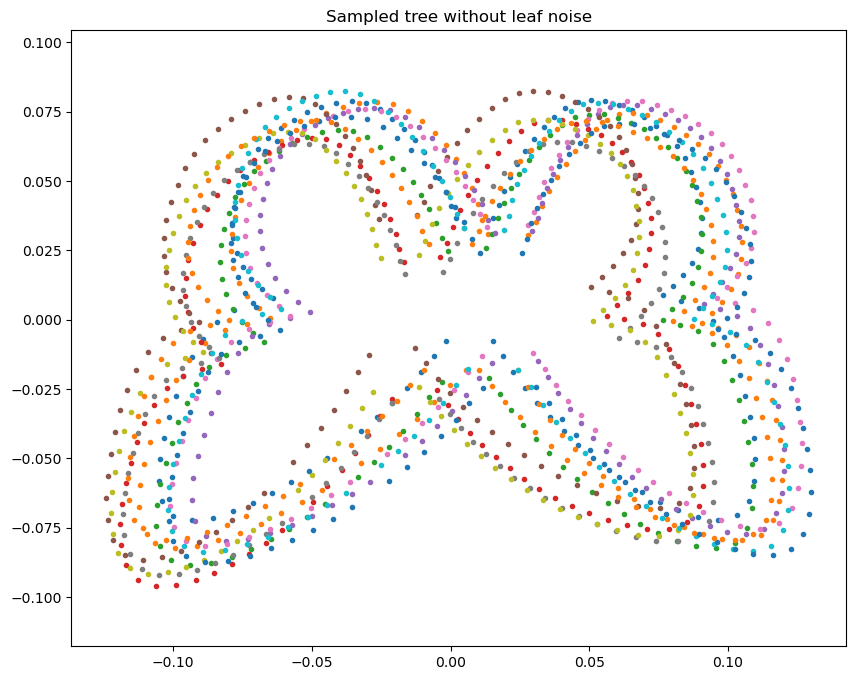

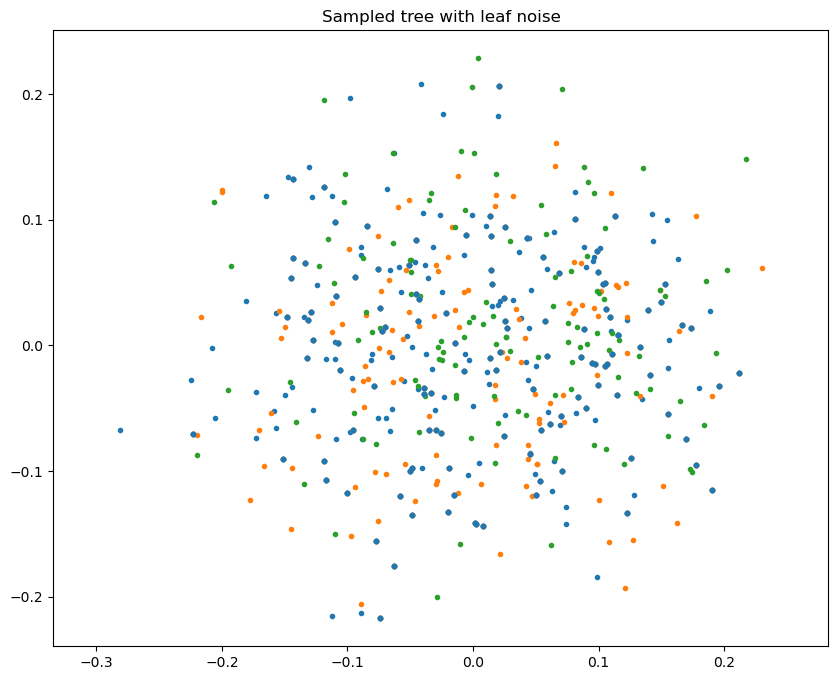

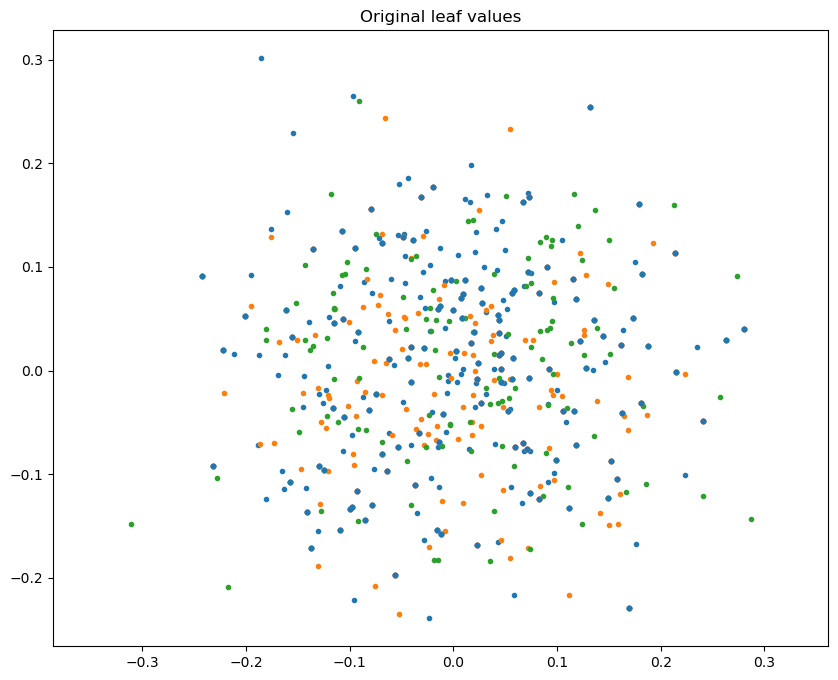

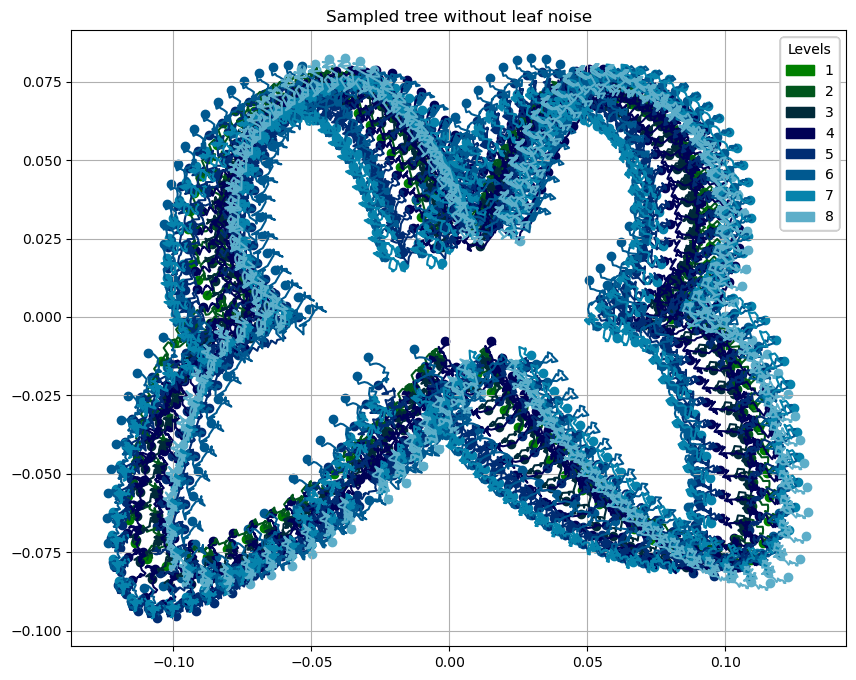